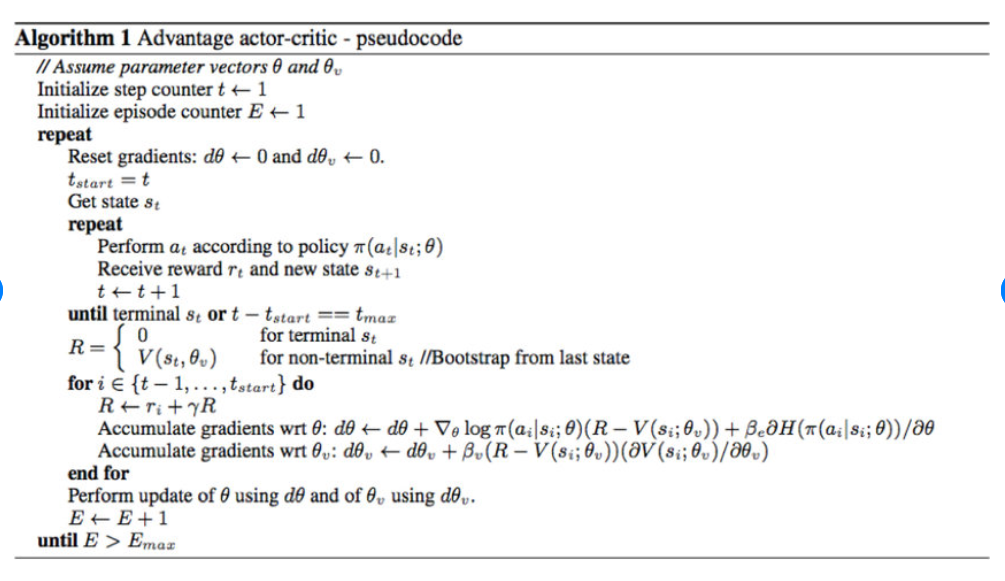

In [1]:
from machine import Machine
from GymMachEnv import MachineEnv
from datetime import datetime
import numpy as np

reference: https://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py

In [2]:
def compute_avg_return(environment, policy, num_episodes):
    total_return = 0.0
    for _ in range(num_episodes):
        state = torch.Tensor(environment.reset())
        state = state.unsqueeze(0)
        episode_return = 0.0 
        while not environment.done:
            action = policy(state).sample()
            next_state, reward, done, _ = environment.step(action)
            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)
            state = next_state
            episode_return += reward
        total_return += episode_return   
    avg_return = total_return / num_episodes
    return avg_return# Evaluate the agent's policy once before training.

# Verify

In [22]:
import gym, os
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

# machine = Machine()
# machine.curr_state = 0
# env = MachineEnv(machine)

# state_size = env.observation_space.shape[0]
# action_size = env.action_space.n
# lr = 0.0001

env = gym.make("CartPole-v0")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
lr = 0.0001

class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
#         self.linear1 = nn.Linear(self.state_size, 128)
#         self.linear2 = nn.Linear(128, 64)
#         self.linear3 = nn.Linear(64, self.action_size)
        self.linear1 = nn.Linear(self.state_size, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear4 = nn.Linear(64, self.action_size)
        self.linear3 = nn.Linear(64, 64)

    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = F.relu(self.linear3(output))
        output = self.linear4(output)
        distribution = Categorical(F.softmax(output, dim=-1))
        return distribution


class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.state_size = state_size
        self.action_size = action_size
#         self.linear1 = nn.Linear(self.state_size, 128)
#         self.linear2 = nn.Linear(128, 64)
#         self.linear3 = nn.Linear(64, 1)
        self.linear1 = nn.Linear(self.state_size, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear4 = nn.Linear(64, 1)
        self.linear3 = nn.Linear(64, 64)


    def forward(self, state):
        output = F.relu(self.linear1(state))
        output = F.relu(self.linear2(output))
        output = F.relu(self.linear3(output))
        value = self.linear4(output)
        return value


def compute_returns(next_value, rewards, masks, gamma=0.9):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns


def trainIters(actor, critic, n_iters):
    optimizerA = optim.Adam(actor.parameters())
    optimizerC = optim.Adam(critic.parameters())
    score_list = []
    for iter in range(n_iters): #episode loop
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()

        for i in count(): #number of steps is equivalent to number of rewards

            state = torch.FloatTensor(state)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            next_state, reward, done, _ = env.step(action.numpy())

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float))
            masks.append(torch.tensor([1-done], dtype=torch.float))

            state = next_state

            if done:
                print("\rIteration: {}, Score: {}".format(iter, i), end="")
                score_list.append(i)
                break

        
        next_state = torch.FloatTensor(next_state)
        next_value = critic(next_state)  #Q value
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
        
    torch.save(actor, 'cart_actor.pkl')
    torch.save(critic, 'cart_critic.pkl')
    env.close()
    return score_list

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

def plot(score):
    df = pd.DataFrame(score)
    moving_ave = df.rolling(10,min_periods=1).mean().values.flatten().tolist()

    ep = [i for i in range(len(score))]
    fig = plt.figure(figsize=(10,10))
    plt.plot(ep,score,label = 'Episodic Reward')
    plt.plot(ep,moving_ave,label = f'Moving Average Window {10}')
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend()
    plt.show()

In [ ]:
ac = Actor(state_size,action_size)
critic = Critic(state_size,action_size)
score = trainIters(ac,critic,300)

In [ ]:
x = torch.FloatTensor(env.reset())

In [ ]:
ac = torch.load('cart_actor.pkl')
y = ac(x).sample()
y.tolist()

In [ ]:
plot(score)

# GMM Model

In [26]:
def trainItersMachine(actor, critic, n_iters,timesteps = None):
    machine = Machine()
    machine.curr_state = 0
    env = MachineEnv(machine)
    
    machine2 = Machine()
    machine2.curr_state = 0
    env2 = MachineEnv(machine2)
    
    
    optimizerA = optim.Adam(actor.parameters(),lr=0.0001)
    optimizerC = optim.Adam(critic.parameters(),lr=0.0001)
    score_list = []
    eval_scores = []
    
    steps = 0
    for iter in range(n_iters):
        state = env.reset()
        log_probs = []
        values = []
        rewards = []
        masks = []
        entropy = 0
        env.reset()
        done = False

        while done == False: #number of steps is equivalent to number of rewards, take full episode
            state = torch.FloatTensor(state)
            dist, value = actor(state), critic(state)

            action = dist.sample()
            next_state, reward, done, _ = env.step(action)

            log_prob = dist.log_prob(action).unsqueeze(0)
            entropy += dist.entropy().mean()

            log_probs.append(log_prob)
            values.append(value)
            rewards.append(torch.tensor([reward], dtype=torch.float))
            masks.append(torch.tensor([1-done], dtype=torch.float))

            state = next_state
            steps+=1
            
            if done:
                print("\rIteration: {}, Score: {}, Steps: {}".format(iter, sum(rewards).numpy()[0], steps),end="")
                score_list.append(sum(rewards).numpy()[0])
                eval_ = compute_avg_return(env2, actor, 20)
                eval_scores.append(eval_)
                break


        next_state = torch.FloatTensor(next_state)
        next_value = critic(next_state)
        returns = compute_returns(next_value, rewards, masks)

        log_probs = torch.cat(log_probs)
        returns = torch.cat(returns).detach()
        values = torch.cat(values)

        advantage = returns - values

        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = advantage.pow(2).mean()

        optimizerA.zero_grad()
        optimizerC.zero_grad()
        actor_loss.backward()
        critic_loss.backward()
        optimizerA.step()
        optimizerC.step()
        
    torch.save(actor, 'actor_3.pt')
    torch.save(critic, 'critic_3.pt')
    env.close()
    return [score_list,eval_scores]

In [27]:
ac2 = Actor(state_size,action_size)
critic2 = Critic(state_size,action_size)
scoreMach = trainItersMachine(ac2,critic2,5000)


Iteration: 4999, Score: 900.0, Steps: 18586691

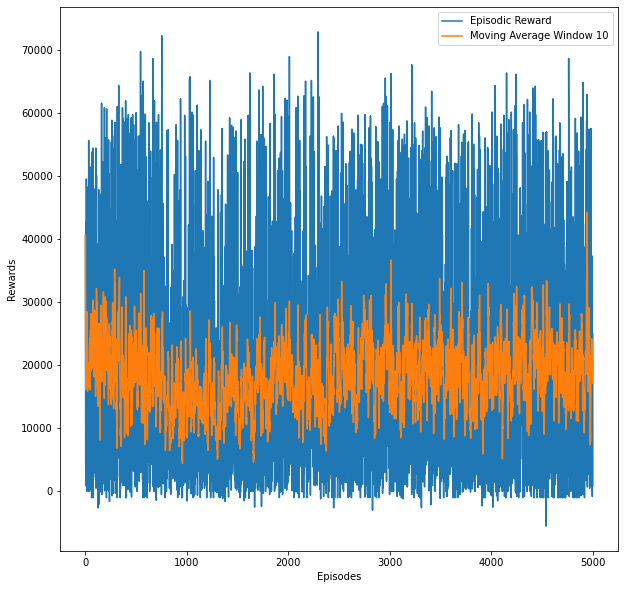

In [28]:
plot(scoreMach[0])

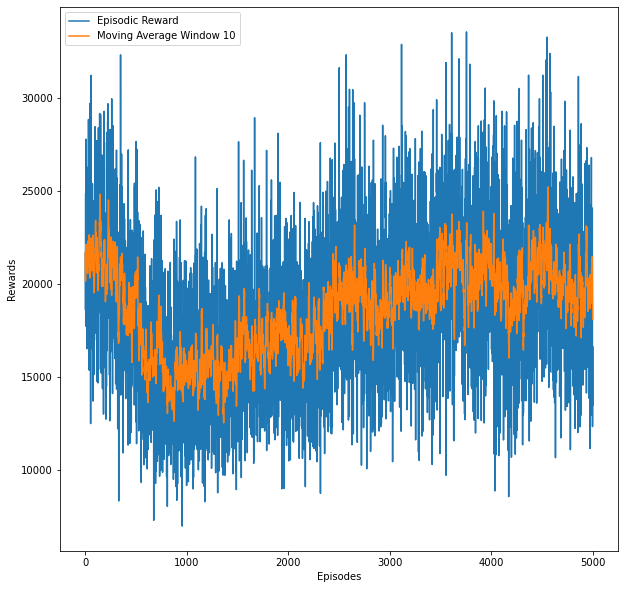

In [29]:
plot(scoreMach[1])

In [ ]:
sum(scoreMach)/len(scoreMach)